# Testing proximal splitting algorithms

### Author : Vincent HERFELD

This notebook will contain different tests I've made whilst reading "Optimization with First Order Algorithms" N. Papadakis et al. 

## 1. First Trials

First we need to choose which problem we want to solve. It will be of the form $\underset{x \in E}{\min} F(x) = \underset{x \in E}{\min} f(x) + \lambda g(x)$.

Where $f$ and $g$ must be convex proper and lsc and we have $f$ is $L$-smooth.


We can consider the classical $L^2$ data fidelity term : $f(x) = \frac{1}{2}||Ax - y||_2^2$, and we can first try out the Lasso where g is a $L^1$ regularisation : $g(x) = ||x||_1$.

In this case $f$ and $g$ are convex, $f$ is differentiable and $|||A^TA|||$-smooth, so we can consider several algorithms.

We will try out deblurring, denoising and inpainting.



In [2]:
def psnr(uref,ut,M=1):
    rmse = np.sqrt(np.mean((np.array(uref)-np.array(ut))**2))
    return 20*np.log10(M/rmse)

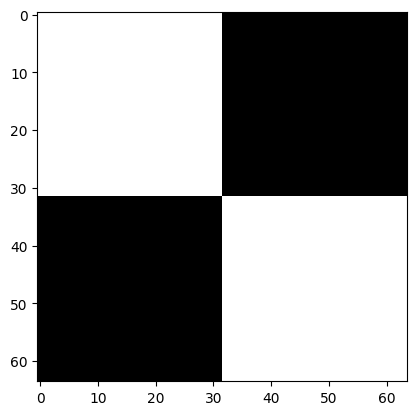

In [3]:
import numpy as np
import matplotlib.pyplot as plt

width, height = 64, 64

x_toy = np.zeros((width, height))

x_toy[:height//2, :width//2] = 1
x_toy[height//2: , width//2:] = 1

plt.imshow(x_toy, cmap="gray")

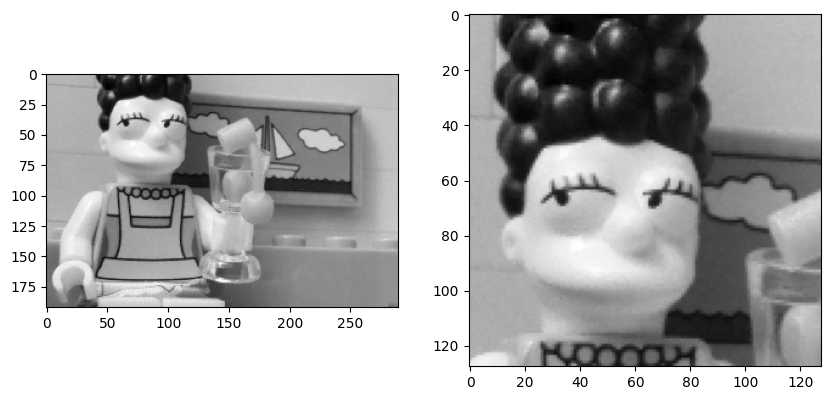

In [20]:
from PIL import Image
x_marge = np.asarray(Image.open('im/simpson512crop.png'))[:, :, 0]
x_marge2 = np.asarray(Image.open('im/marge2.png'))[:, :, 0]

images = [x_marge2, x_marge]

_, axs = plt.subplots(1, len(images), figsize = (10,10))
for ax, y in zip(axs.flatten(), images):
    ax.imshow(y, cmap="gray")
plt.show()

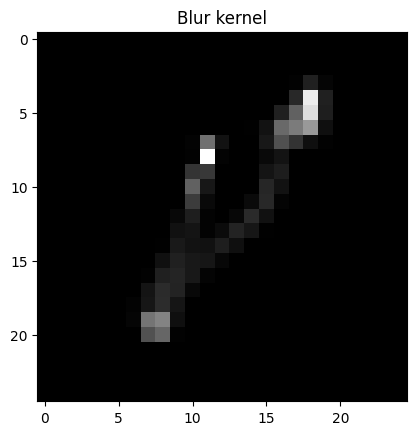

In [21]:
from numpy.fft import ifft2, fft2

#denoising
def noise(x):
    return x, np.eye(N = x.shape[0])

#inpainting
def mask(x):
    x_f = x.flatten()
    m = x_f.shape[0]
    dg = np.ones(x_f.shape)
    dg[m // 4 : m // 2] = 0

    A = np.diag(dg)
    
    #uncomment to see mask matrix
    #plt.imshow(A)
    #plt.show()

    return (A @ x_f).reshape(x.shape), A.T

#inpainting
def rand_mask(x):
    x_f = x.flatten()
    m = x_f.shape[0]
    dg = np.random.randint(2, size=x_f.shape)

    A = np.diag(dg)
    
    #uncomment to see mask matrix
    #plt.imshow(A)
    #plt.show()

    return (A @ x_f).reshape(x.shape), A.T


kt = np.loadtxt('kernels/kernel8.txt')
plt.imshow(kt, cmap="gray")
plt.title('Blur kernel')
plt.show()

#debluring
def blur(x, kt = kt):
    # kt = np.loadtxt('kernels/levin7.txt')
    (m,n) = kt.shape

    # Embed the kernel in a MxNx3 image, and put center at pixel (0,0)
    k = np.zeros(x.shape)
    k[0:m,0:n] = kt/np.sum(kt)
    k = np.roll(k,(-int(m/2),-int(n/2)),(0,1))

    fk = fft2(k)   

    return np.real(ifft2(fk * fft2(x))), np.conj(fk)



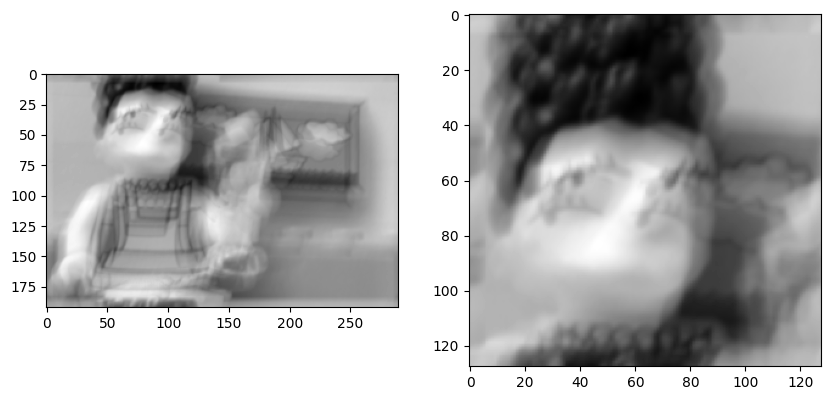

In [6]:
#A = mask
#A = rand_mask
#A = noise
A = blur

sigma = 0.1



observations = []
transposes = []

for x in images:
    Ax = A(x)
    y, A_T = (Ax[0]+ sigma*np.random.normal(size=x.shape), Ax[1])
    observations.append(y)
    transposes.append(A_T)


_, axs = plt.subplots(1, len(images), figsize = (10,10))
for ax, y in zip(axs.flatten(), observations):
    ax.imshow(y, cmap="gray")
plt.show()



Once we have built our observation $y$ we need to implement the algorithms, these rely on proximal operators and computing them can be complicated. In the case of the Lasso, we have : $g(x) = ||x||_1 = \sum_{i=1}^n |x_i|$ so $g(x)$ is seperable in the components of $x = (x_i)_i$, such that $g(x) = ||x||_1 = \sum_{i=1}^n u(x_i)$. We have seen in the optimization handbook that the Proximal operator of a sum of seperable functions is the vector containing each proximal operator : 

$f(x) = f_1(x_1)+ f_2(x_2) + ... + f_n(x_n) \Rightarrow Prox_f(x) = (Prox_{f_1}(x_1),Prox_{f_2}(x_2), ..., Prox_{f_n}(x_n) )$.

We can compute $Prox_{\lambda |.|}(x) = \underset{y}{\text{argmin } } \lambda |y| + \frac{1}{2}|x - y|^2 = \underset{y}{\text{argmin } } h(y)$. The function we want to minimize here is convex coercive, proper, lsc, but not differentiable in 0. We split in 3 cases and compute the gradient when possible :

if $y > 0, \nabla h (y) = \lambda + y - x = 0 \Leftrightarrow y = x - \lambda$ if $x > \lambda$ (since $y$ has to be positive)\
if $y < 0, \nabla h (y) = -\lambda + y - x = 0 \Leftrightarrow y = x + \lambda$ if $x < -\lambda$ (since $y$ has to be negative)\
in $y=0,\; \partial h(0) = [-1, 1]$ and since $0 \in \partial h(0)$ we can say that $0$ is a minimizer of $h$ (this holds if $|x| \leq \lambda$).

Finally, we can write : $Prox_{\lambda |.|}(x) = \min(x - sign(x)\lambda, 0)$

We need to choose an appropriate $\lambda$ that verifies $\lambda < \frac{2}{L}$, and since $L = |||A^TA|||$ we must adapt to the problem.

In the case of deblurring we have a blurring kernel and we can see applying A as doing a convolution, and by Parseval we conserve energy in the fourier space. So $L = |||A^TA||| = ||\bar{\hat{k}}\times \hat{k}|| = ||\hat{k}||^2$. 

I remember that during our course Arthur Leclaire told us that in our case $|\hat{k}|^2 = 1$ so I will assume so.

In [17]:
L = 1
lmda = 0.9 * 2 / L

f = lambda x, y : np.sum((A(x)[0] - y)**2) / 2

grad_f = lambda x, A_T, y :  (A_T @ (A(x)[0] - y).flatten()).reshape(x.shape) if A != blur else np.real(ifft2(A_T * fft2((A(x)[0] - y))))

prox_g = lambda x : np.array([np.min(x_i - np.sign(x_i)*lmda, 0) for x_i in x.flatten()]).reshape(x.shape)

In [18]:
def plot_images(images, X_k, groundtruths, i, n_iter):
    fig, axs = plt.subplots(1, len(images), figsize = (10,10))
    for ax, x_k, gt in zip(axs.flatten(), X_k, groundtruths):
        ax.set_title(f"psnr : {psnr(x_k, gt)}")
        ax.imshow(x_k, cmap="gray")
    if i == 0:
        fig.suptitle("Initial observations")
    elif i == n_iter:
        fig.suptitle("Final observations")
    else:
        fig.suptitle(f"Iteration : {i}")
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.7)
    plt.show()

def Forwardbackward(observations, groundtruths, transposes, n_iter = 20):
    X_k = observations.copy()
    plot_images(images, X_k, groundtruths, 0, n_iter)
    
    for i in range(1, n_iter):
        for indx in range(len(observations)):
            x_tilde = X_k[indx] - lmda*grad_f(X_k[indx], transposes[indx], observations[indx])
            X_k[indx] = prox_g(x_tilde)
        
        if i % 50 == 0:
            plot_images(images, X_k, groundtruths, i, n_iter)
    
    plot_images(images, X_k, groundtruths, n_iter, n_iter)
    return X_k

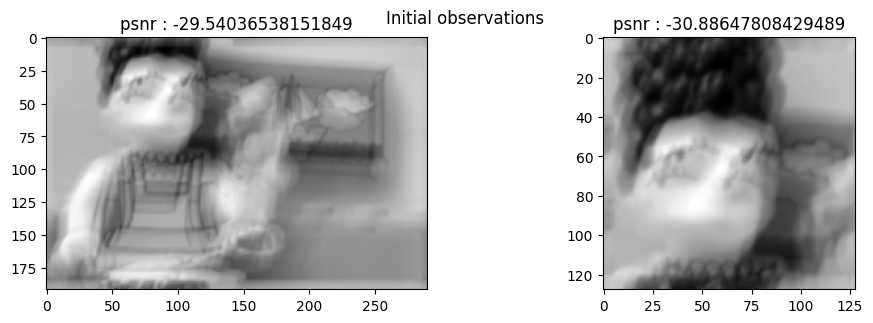

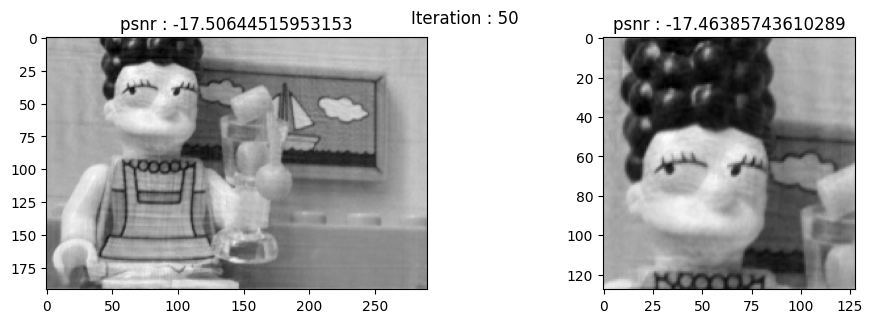

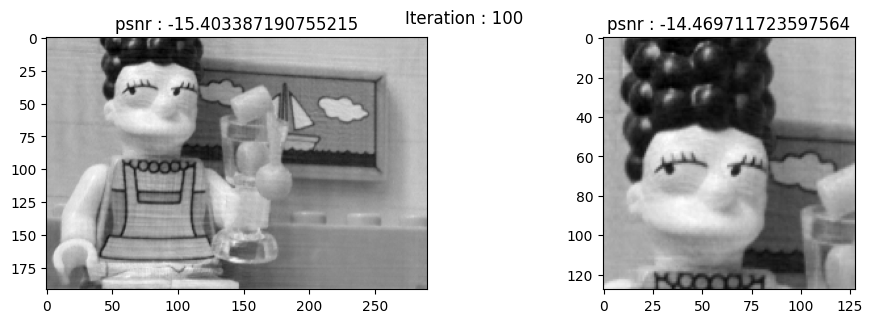

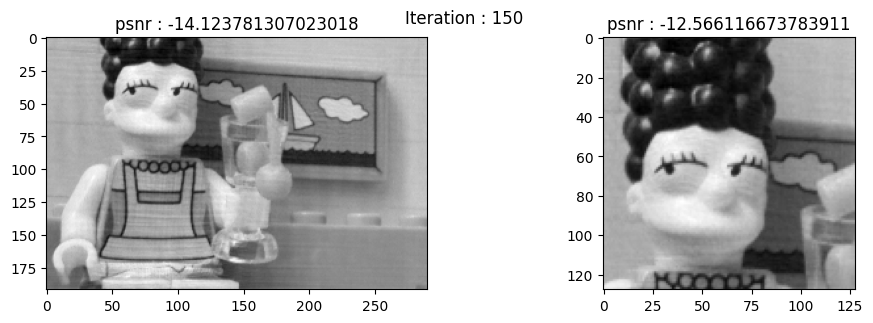

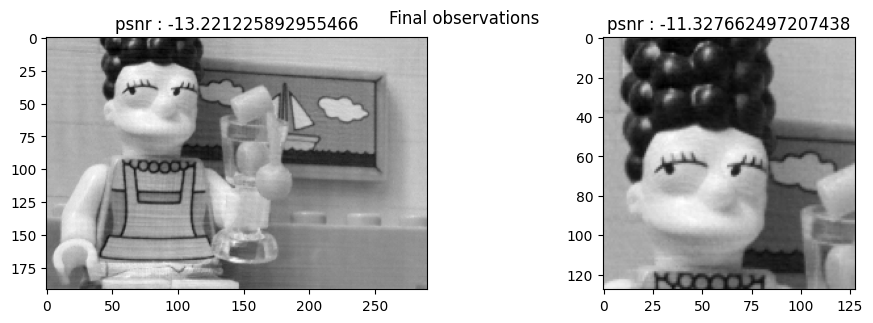

In [19]:
x_est = Forwardbackward(observations, images, transposes, n_iter = 200)

In [15]:
def FISTA(observations, groundtruths, transposes, n_iter = 20):
    X_k = observations.copy()
    plot_images(images, X_k, groundtruths, 0, n_iter)

    t = np.ones(n_iter)
    for i in range(1,n_iter):
        t[i] = (1 + np.sqrt(1 + 4*t[i-1]**2)) / 2
    
    for i in range(1, n_iter):
        X_k_prev = X_k.copy()
        for indx in range(len(observations)):
            x_k = X_k[indx]
            x_prev = X_k_prev[indx]
            y_tilde = x_k + t[i-1] * (x_k - x_prev) / t[i]
            x_tilde = y_tilde - lmda*grad_f(y_tilde, transposes[indx], observations[indx])
            X_k[indx] = prox_g(x_tilde)
        
        
        if i % 50 == 0:
            plot_images(images, X_k, groundtruths, i, n_iter)
    
    plot_images(images, X_k, groundtruths, n_iter, n_iter)
    return X_k

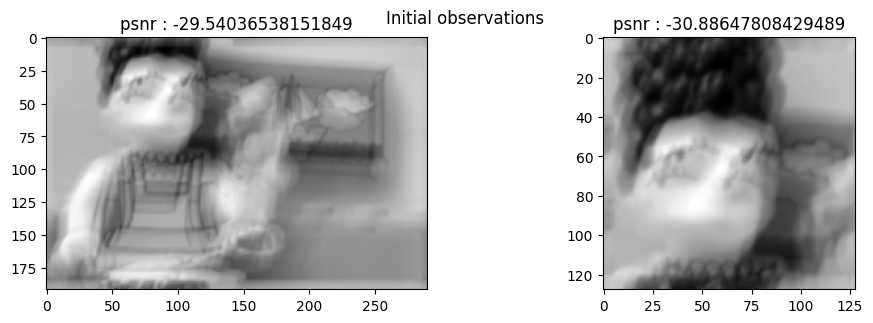

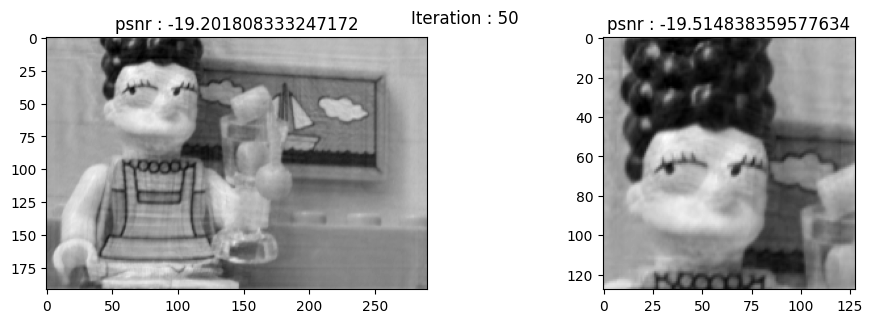

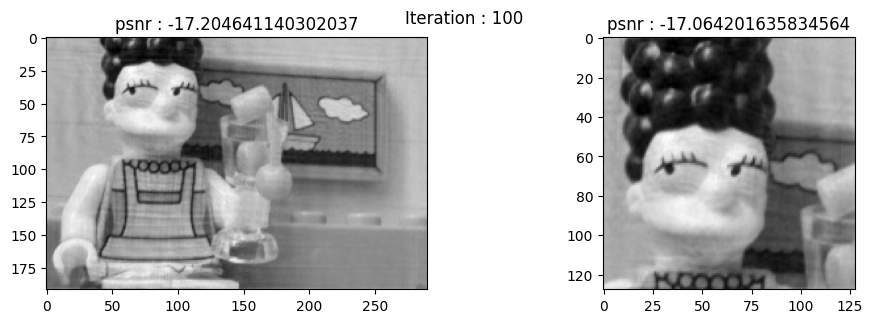

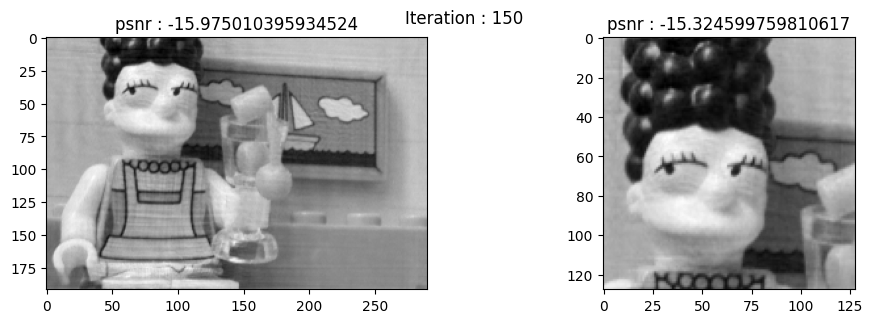

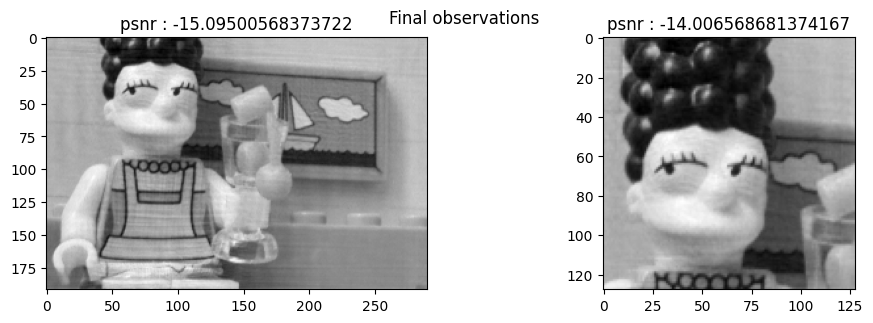

In [16]:
x_est = FISTA(observations, images, transposes, n_iter = 200)

In chapter 7 it is also explained that for the Lasso the objective is even $||A||$-strongly convex, so we can use the V-FISTA algorithm.

## Issues :

I've successfully implemented masking functions but since I flatten the image the considered operator is a very large matrix, so computations are very slow.. I would need to discover a trick to avoid my kernel to crash (maybe using GPU ?). Else maybe there is another way to solve inpainting..

## Next trials :

- Douglas-Rachford
- Other regularizations
- Other data fidelity terms
- Look at PnP methods where you replace the prox by a Deep Denoiser
- Find a way to properly do RGB\
.\
.\
.
